## Gradient Tree Boosting Classifier

This file uses gradient tree boosting to classify villages in Bihar, India into 2 groups:
1. unelectrified (<10% households are electrified)
2. electrified (>= 10% households are electrified)  

In addition, scholars in literature review have suggested that small villages emit such weak lights-at-night that satellites may have difficulty accurately picking it up. Thus we filter out too-small villages.  
Here our inputs are 3 dataframes of villages:  
1. all villages in dataset
2. villages with at least 100 households
3. villages with at least 400 households

Each dataframe contains:  
1. village identifiers, such as name and ID
2. features extracted from lights at night image (different code file!)
 
In this code, we run gradient tree boosting on all three dataframes, and evaluate classification results on ROC curves.  
Thanks for reading!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math, os
from pandas.plotting import scatter_matrix
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from seaborn import heatmap

In [2]:
'''
Load data from .csv file  
dfall = all households included
df100 = threshold: 100 households (subset of dfall)
df400 = threshold: 400 households (subset of dfall)
'''
dfall = pd.read_csv('multiple_features_with_ndvi_green.csv')
del dfall['Unnamed: 0']
# del dfall['Percentage Electrified_x']
# del dfall['Percentage Electrified']
# dfall[dfall.isna()]
dfall = dfall.replace(np.nan, -1)

dfall = dfall.rename(columns={'Number of Households': 'Number_of_Households'})
df100 = dfall.query('Number_of_Households > 100')
df400 = dfall.query('Number_of_Households > 400')

# matching up header titles
# dfall['Percentage Electrified_x'] = dfall['Percentage Electrified']
# dfall['Village Name_x'] = dfall['Village Name']

dfall.head()

,Census 2011 ID,Village Name,Number_of_Households,Number of Electrified Households,Percentage Electrified,min,10th_percentile,median,90th_percentile,max,...,b4_std,b5_max,b5_mean,b5_std,b6_max,b6_mean,b6_std,b7_max,b7_mean,b7_std
0,215989,Kalapani,445,42,9.438202,0.203942,0.265501,0.324645,0.464612,0.523828,...,0.009572,0.392333,0.256652,0.029838,0.239994,0.109840,0.016523,0.212416,0.042186,0.012073
1,215991,Tharhi,339,214,63.126844,0.086101,0.172867,0.260938,1.104471,3.988446,...,0.040807,0.433900,0.228521,0.076307,0.364525,0.158865,0.067637,0.329995,0.096955,0.060730
2,215992,Pipra,107,59,55.140187,0.370665,0.425144,0.872517,1.678522,1.801801,...,0.022359,0.392705,0.238559,0.060288,0.290201,0.140633,0.044509,0.232556,0.073257,0.034742
3,215993,Kotaraha,128,64,50.000000,0.225840,0.274397,0.424527,0.990788,2.246413,...,0.017670,0.411615,0.260138,0.061775,0.299013,0.131846,0.036350,0.229781,0.060575,0.027763
4,215995,Lachhmipur,615,449,73.008130,0.211082,0.281324,0.339738,0.590184,1.232227,...,0.016121,0.384866,0.234281,0.046209,0.307109,0.151011,0.032869,0.233729,0.079388,0.028700


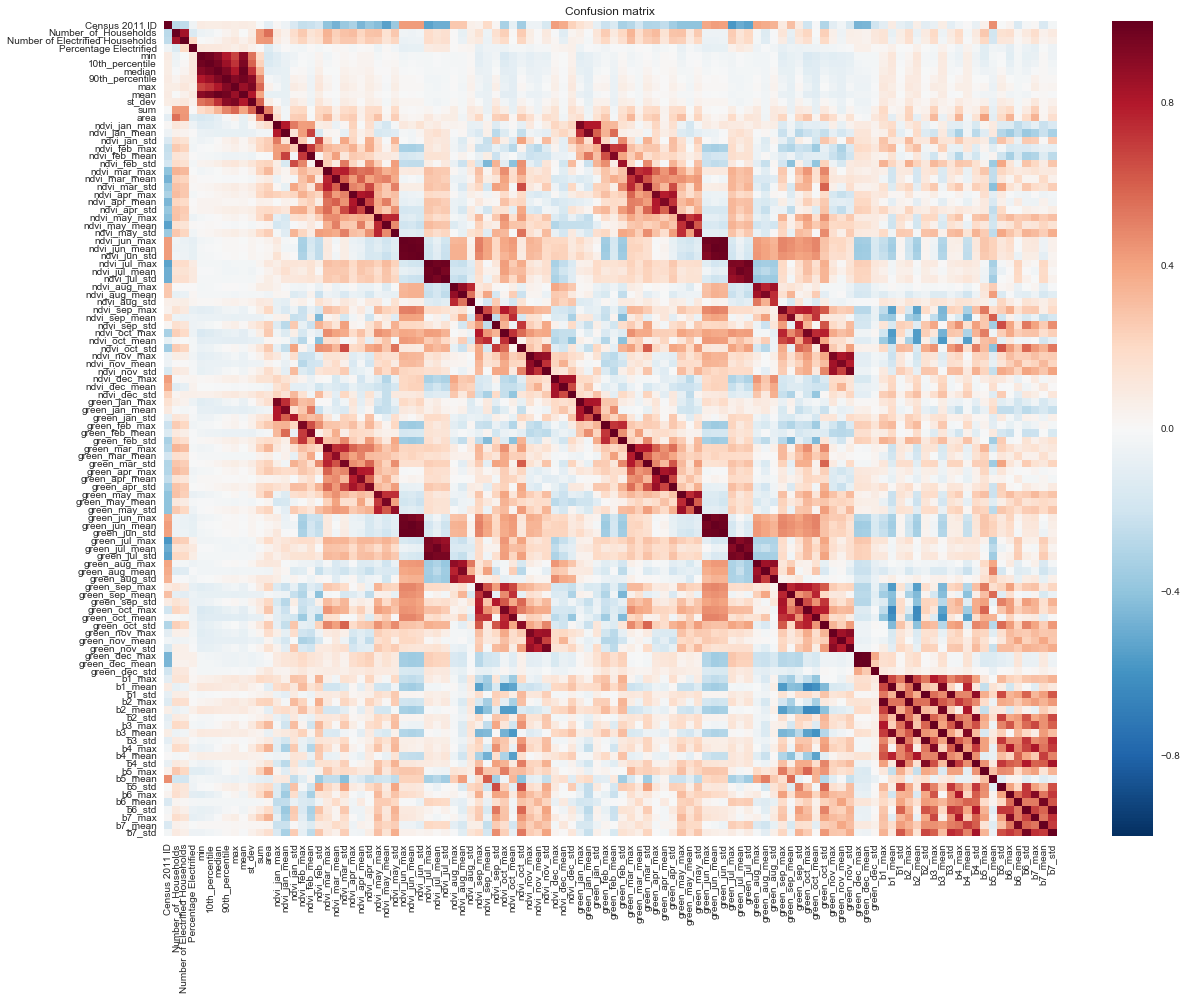

In [3]:
corr_matrix = dfall.corr()
plt.figure(figsize=(20,15))
heatmap(corr_matrix)
plt.title("Confusion matrix")
plt.show()

In [4]:
'''
Assigns an electrification category to each village based on its percentage
Keeping this binary and with threshold 10% for now. 
'''
threshold = 50 
labels_all = (dfall['Percentage Electrified'] >= threshold).tolist()
labels_100 = (df100['Percentage Electrified'] >= threshold).tolist()
labels_400 = (df400['Percentage Electrified'] >= threshold).tolist()
del dfall['Percentage Electrified']
del df100['Percentage Electrified']
del df400['Percentage Electrified']
del dfall['Number of Electrified Households']
del df100['Number of Electrified Households']
del df400['Number of Electrified Households']
# del dfall['Percentage Electrified_x']
# del df100['Percentage Electrified_x']
# del df400['Percentage Electrified_x']

dfall.head()

for i in dfall.columns:
    if dfall[i].dtype == "object":
        del dfall[i]
for i in df100.columns:
    if df100[i].dtype == "object":
        del df100[i]
for i in df400.columns:
    if df400[i].dtype == "object":
        del df400[i]

training_data = [dfall, df100, df400]
training_label = [labels_all, labels_100, labels_400]

In [22]:
def plot_pca(data_list, label_list, max_conponents):
    plt.figure(figsize=(20,15))
    result = {}
    for data, label in zip(data_list, label_list):
        PCA_components = []
        score = []
        scaler = StandardScaler()
        data_transformed = scaler.fit_transform(data)
        for i in range(1,max_conponents):
            pca = PCA(n_components=i)
            PCA_components.append(i)
            pca.fit(data_transformed, label)
            var_values = pca.explained_variance_ratio_
            score.append(sum(var_values))
            if i not in result:
                result[i] = []
            result[i].append(sum(var_values))
        plt.plot(PCA_components, score)
    plt.ylabel("Expalined variance")
    plt.xlabel("number of features employed")
    plt.title("Principle Component Analysis")
    plt.show()
    return result

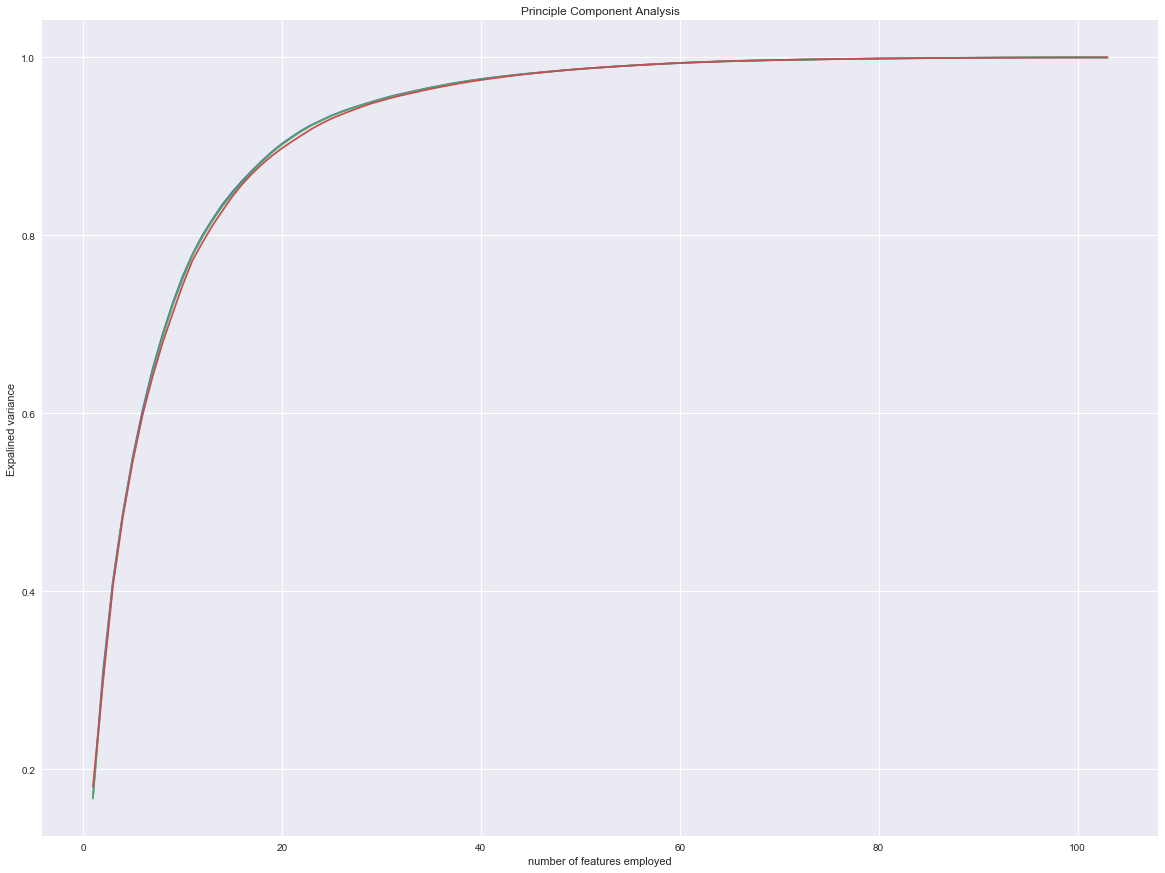

In [23]:
pca_scores = plot_pca(training_data, training_label, len(training_data[0].columns))

In [24]:
for i in pca_scores:
    if np.mean(pca_scores[i]) > 0.99 and np.mean(pca_scores[i]) < 0.999:
        print(i, np.mean(pca_scores[i]))

54 0.990135539811
55 0.990813966781
56 0.991470144371
57 0.992082029857
58 0.992658716155
59 0.99320720925
60 0.993727451403
61 0.994223239752
62 0.994650186199
63 0.995051507381
64 0.995427176078
65 0.995775058651
66 0.996079820875
67 0.996351599737
68 0.996606184571
69 0.996845521109
70 0.997070912992
71 0.997280056835
72 0.997472031399
73 0.997655314591
74 0.997826653083
75 0.997988261974
76 0.998145337779
77 0.9982944264
78 0.99843789739
79 0.998571012423
80 0.998695972561
81 0.99881441777
82 0.998925853207


In [25]:
def pca_transform(data, labels):
    n_components = 50
    pca = PCA(n_components=n_components)
    return pd.DataFrame(pca.fit_transform(data, labels))

In [26]:
new_dfall = pca_transform(dfall, labels_all)
new_df100 = pca_transform(df100, labels_100)
new_df400 = pca_transform(df400, labels_400)

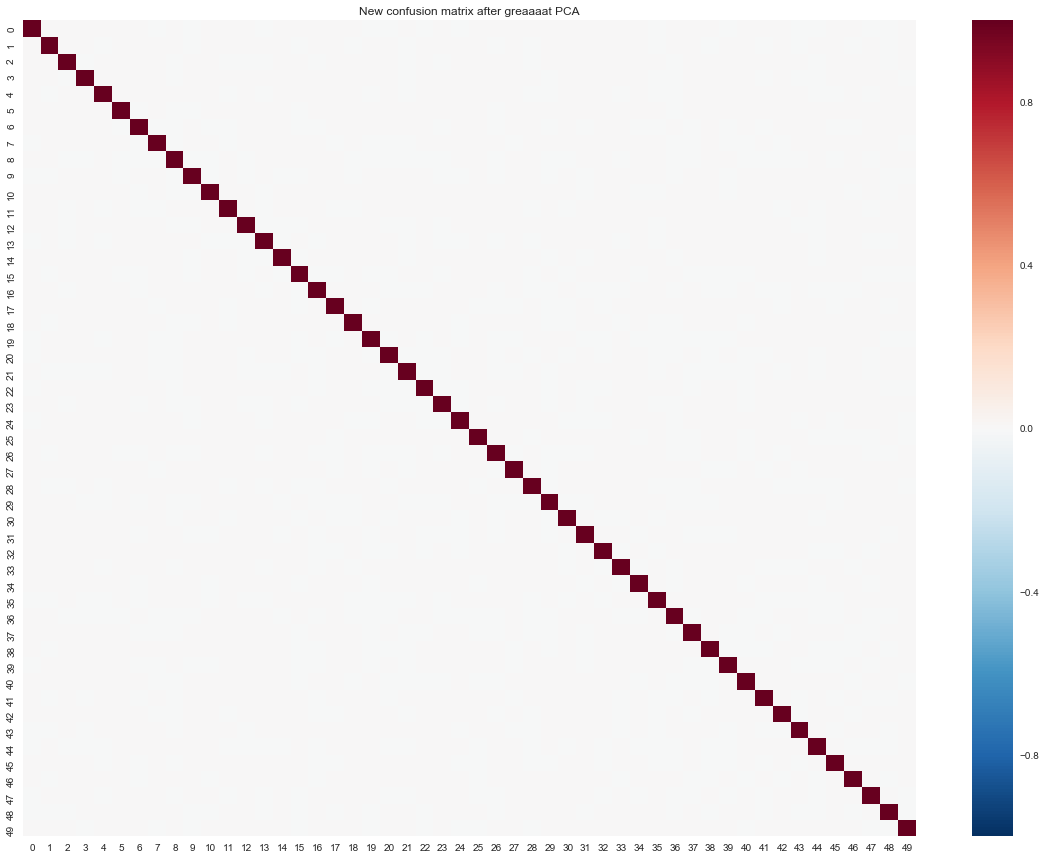

In [27]:
new_corr_matrix = new_dfall.corr()
plt.figure(figsize=(20,15))
heatmap(new_corr_matrix)
plt.title("New confusion matrix after greaaaat PCA")
plt.show()

In [28]:
print(new_dfall.shape)

(32820, 50)


In [12]:
print(dfall.columns)

Index(['Census 2011 ID', 'Number_of_Households', 'min', '10th_percentile',
       'median', '90th_percentile', 'max', 'mean', 'st_dev', 'sum',
       ...
       'b4_std', 'b5_max', 'b5_mean', 'b5_std', 'b6_max', 'b6_mean', 'b6_std',
       'b7_max', 'b7_mean', 'b7_std'],
      dtype='object', length=104)


In [13]:
rand = np.random.rand(new_dfall.shape[0]) < 0.8
training = new_dfall[rand]
training_labels = [i for i,cond in zip(labels_all, rand) if cond]
testing = new_dfall[~rand]
testing_labels = [i for i,cond in zip(labels_all, rand) if not cond]

In [14]:
maximum = 0
for n in range(50, 150, 20):
    for d in range(2, 8):
        gdb = GradientBoostingClassifier(n_estimators=n, max_depth=d)
        gdb.fit(training, training_labels)
        probability = gdb.predict_proba(testing)[::,1]
        if roc_auc_score(testing_labels, probability) > maximum:
            maximum = roc_auc_score(testing_labels, probability)
        print(n, d, roc_auc_score(testing_labels, probability).round(3))

50 2 0.686
50 3 0.705
50 4 0.714
50 5 0.718
50 6 0.721
50 7 0.722
70 2 0.692
70 3 0.711
70 4 0.718
70 5 0.719
70 6 0.723
70 7 0.721
90 2 0.697
90 3 0.713
90 4 0.719
90 5 0.72
90 6 0.722
90 7 0.721
110 2 0.701
110 3 0.714
110 4 0.719
110 5 0.722
110 6 0.724
110 7 0.721
130 2 0.704
130 3 0.715
130 4 0.721
130 5 0.722
130 6 0.723
130 7 0.721


In [15]:
def gdb_machine(data, labels):
#     rand = np.random.rand(len(labels)) < 0.8
#     training = data[rand]
#     training_labels = [i for i,cond in zip(labels, rand) if cond]
#     testing = data[~rand]
#     testing_labels = [i for i,cond in zip(labels, rand) if not cond]
    gdb = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)
    gdb.fit(data, labels)
    predictions = gdb.predict(data)
    probailities = gdb.predict_proba(data)[::,1]
    return(predictions, probailities, labels)

In [16]:
pred_all, prob_all, test_all = gdb_machine(dfall, labels_all)
pred_100, prob_100, test_100 = gdb_machine(df100, labels_100)
pred_400, prob_400, test_400 = gdb_machine(df400, labels_400)
pred_all_new, prob_all_new, test_all_new = gdb_machine(new_dfall, labels_all)
pred_100_new, prob_100_new, test_100_new = gdb_machine(new_df100, labels_100)
pred_400_new, prob_400_new, test_400_new = gdb_machine(new_df400, labels_400)

In [17]:
fpr_all, tpr_all, thresholds = roc_curve(test_all, prob_all)
fpr_100, tpr_100, thresholds = roc_curve(test_100, prob_100)
fpr_400, tpr_400, thresholds = roc_curve(test_400, prob_400)
fpr_all_new, tpr_all_new, thresholds = roc_curve(test_all_new, prob_all_new)
fpr_100_new, tpr_100_new, thresholds = roc_curve(test_100_new, prob_100_new)
fpr_400_new, tpr_400_new, thresholds = roc_curve(test_400_new, prob_400_new)

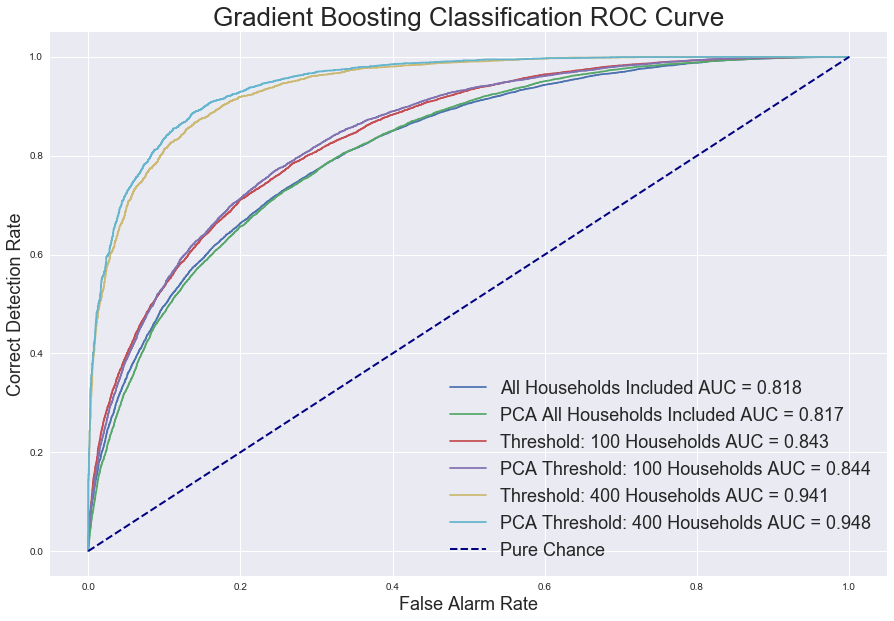

In [18]:
plt.figure(figsize=(15,10))
plt.plot(fpr_all, tpr_all,label="All Households Included AUC = "+str(roc_auc_score(test_all, prob_all).round(3)))
plt.plot(fpr_all_new, tpr_all_new,label="PCA All Households Included AUC = "+str(roc_auc_score(test_all_new, prob_all_new).round(3)))
plt.plot(fpr_100, tpr_100,label="Threshold: 100 Households AUC = "+str(roc_auc_score(test_100, prob_100).round(3)))
plt.plot(fpr_100_new, tpr_100_new,label="PCA Threshold: 100 Households AUC = "+str(roc_auc_score(test_100_new, prob_100_new).round(3)))
plt.plot(fpr_400, tpr_400,label="Threshold: 400 Households AUC = "+str(roc_auc_score(test_400, prob_400).round(3)))
plt.plot(fpr_400_new, tpr_400_new,label="PCA Threshold: 400 Households AUC = "+str(roc_auc_score(test_400_new, prob_400_new).round(3)))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Pure Chance")
plt.legend(loc=4, fontsize=18)
plt.xlabel('False Alarm Rate', fontsize=18)
plt.ylabel('Correct Detection Rate', fontsize=18)
plt.title('Gradient Boosting Classification ROC Curve', fontsize=26)
plt.show()

In [19]:
sum(pred_all_new != test_all)

8543

In [20]:
sum(pred_100 != test_100)

5646

In [21]:
sum(pred_400 != test_400)

1090